<a href="https://colab.research.google.com/github/10Vaibhav/Hyperspectral-Satellite-Image-Classification-By-Deep-CNNs/blob/main/HyperSpectralClassification_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install earthpy

# Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Dropout, Flatten, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

seed(11)

In [3]:
## GLOBAL VARIABLES
test_ratio = 0.3
windowSize = 3

# Required Functions

In [4]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)

      return X_train, X_test, y_train, y_test

In [5]:
# if you want to have inputs and outputs, map size should be the same then we need zero padding
def padWithZeros(X, margin=2):
  newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
  x_offset = margin
  y_offset = margin
  newX[x_offset:X.shape[0]+x_offset, y_offset: X.shape[1] + y_offset, :] = X
  return newX

In [6]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
  margin = int((windowSize -1)/ 2)
  zeroPaddedX = padWithZeros(X, margin=margin)
  # split patches
  patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
  patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
  patchIndex = 0
  for r in range(margin, zeroPaddedX.shape[0] - margin):
    for c in range(margin, zeroPaddedX.shape[1]- margin):
      patch = zeroPaddedX[r - margin:r + margin + 1, c - margin: c + margin + 1]
      patchesData[patchIndex, :, :, :] = patch
      patchesLabels[patchIndex] = y[r-margin, c-margin]
      patchIndex = patchIndex + 1
  if removeZeroLabels:
    patchesData = patchesData[patchesLabels>0, :, :, :]
    patchesLabels = patchesLabels[patchesLabels>0]
    patchesLabels -= 1
  return patchesData, patchesLabels

# Load Data

In [7]:
# X data (1096, 715, 102) Hyperspectral satellite (1096*715, 102)
data = loadmat('Pavia.mat')['pavia']

In [8]:
gt = loadmat('Pavia_gt.mat')['pavia_gt']

In [9]:
print(f'Data Shape: {data.shape[:-1]} \n Number of Bands: {data.shape[-1]}')

Data Shape: (1096, 715) 
 Number of Bands: 102


In [10]:
x,y = createImageCubes(data, gt, windowSize=windowSize)
x.shape, y.shape

((148152, 3, 3, 102), (148152,))

In [14]:
x_train, x_test, y_train, y_test = splitTrainTestSet(x, y, test_ratio)
x_train, x_val, y_train, y_val = splitTrainTestSet(x_train, y_train, test_ratio)

# Data Visualization


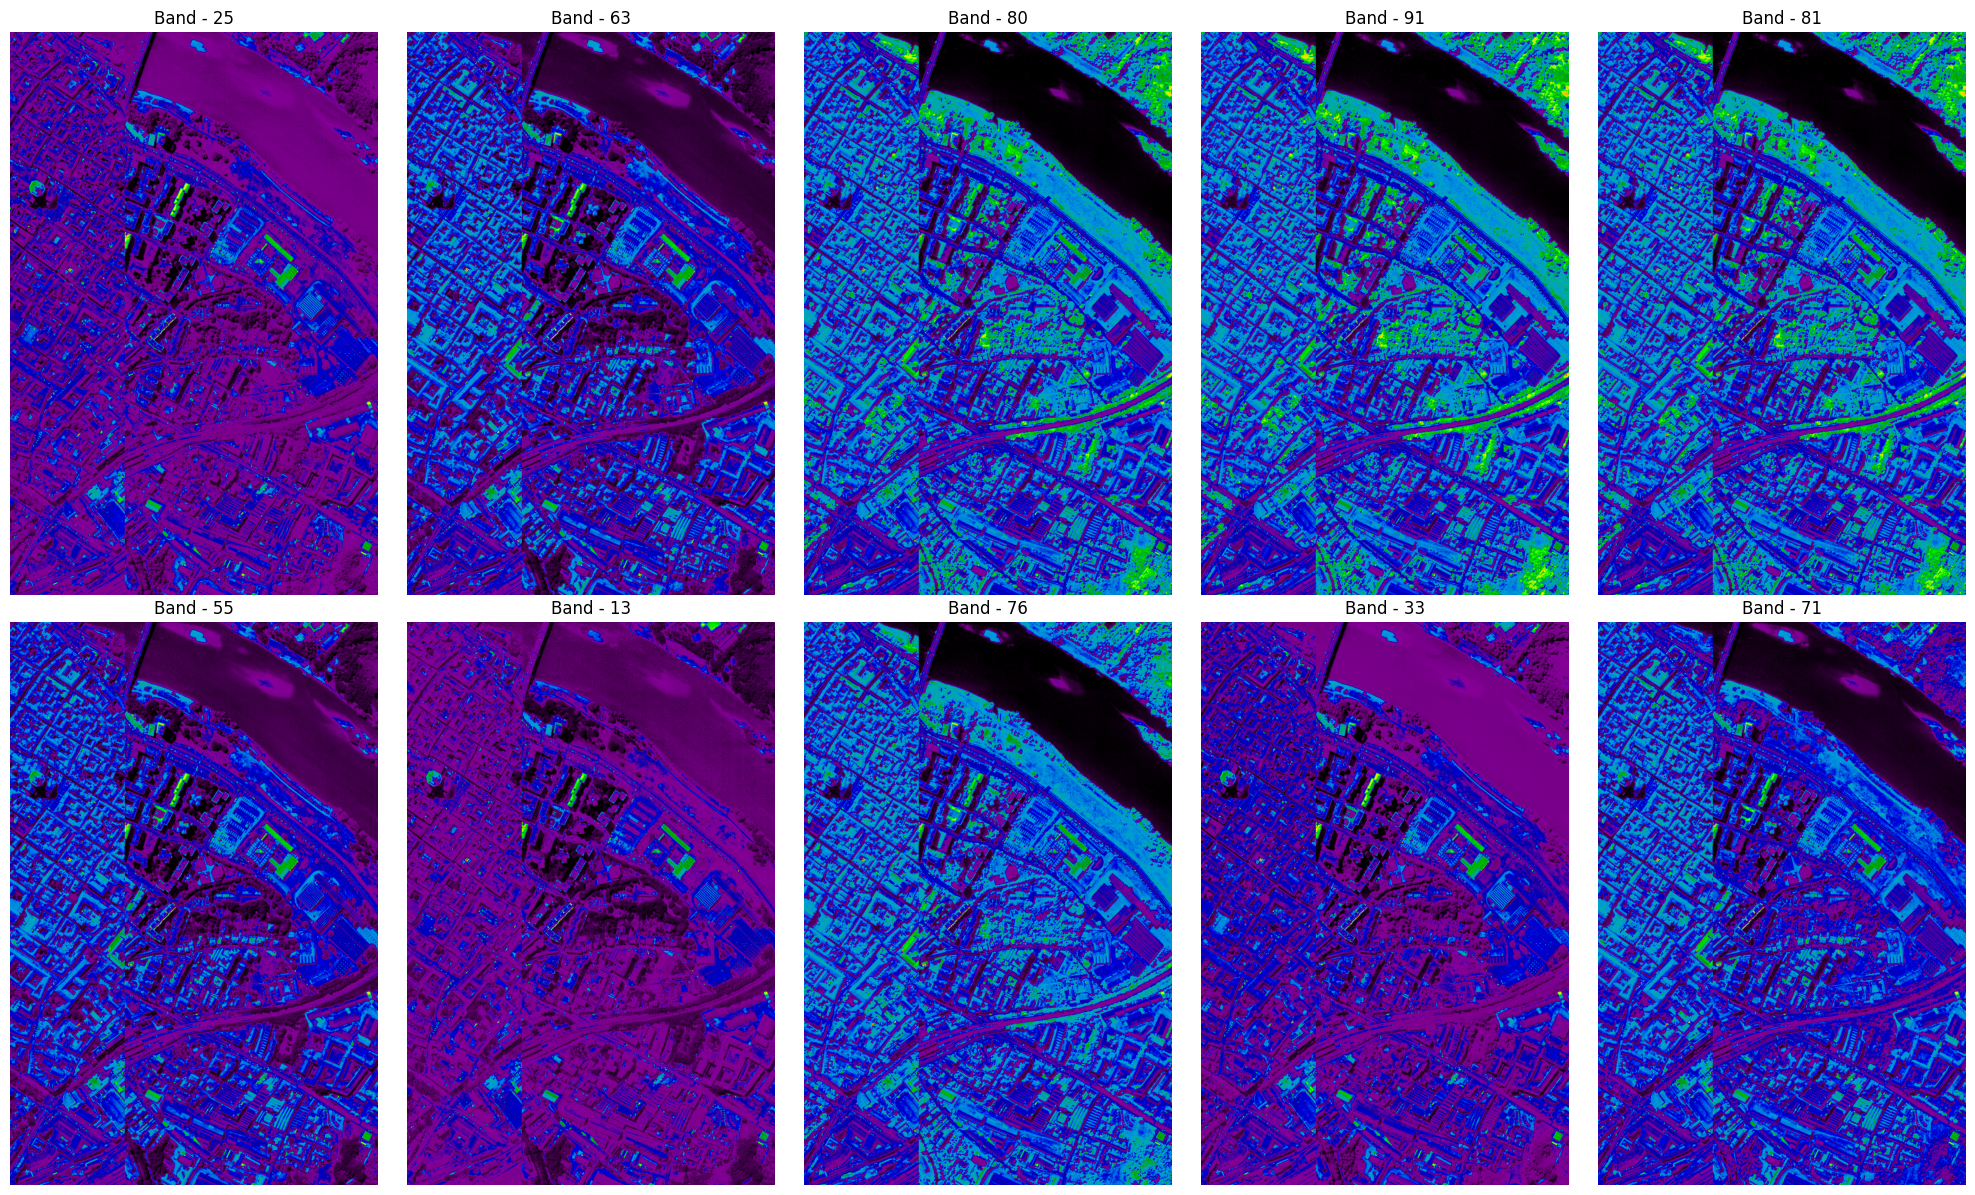

In [18]:
fig = plt.figure(figsize = (20, 12))
ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:,:,c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()


# RGB Composite Image

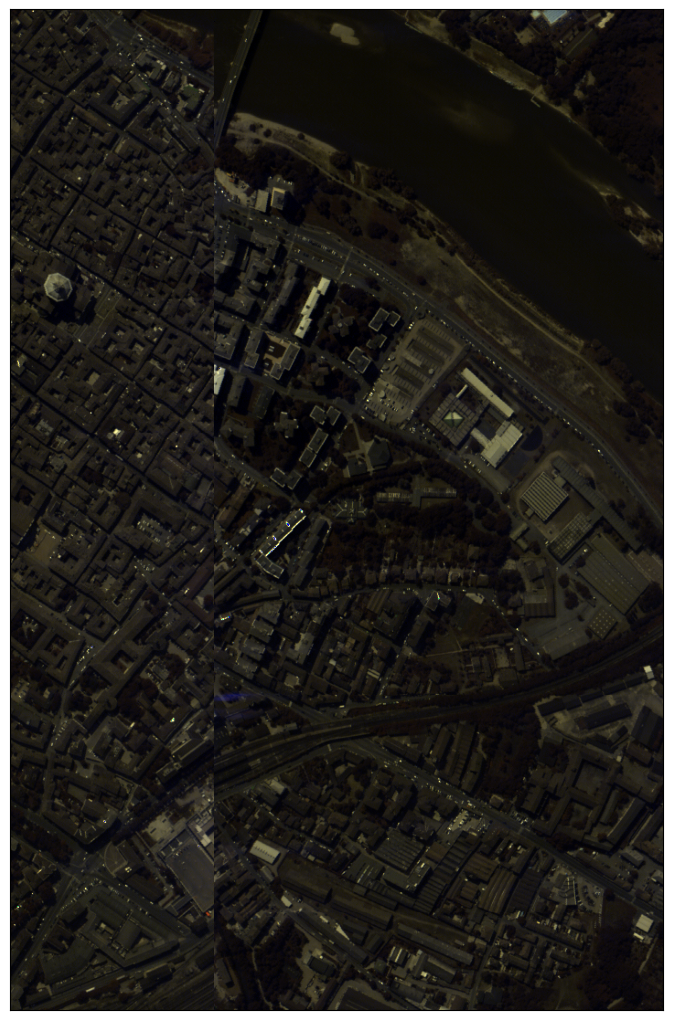

In [21]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (29,23,2), figsize=(15,13))

plt.show()

# GroundTruth Visualization

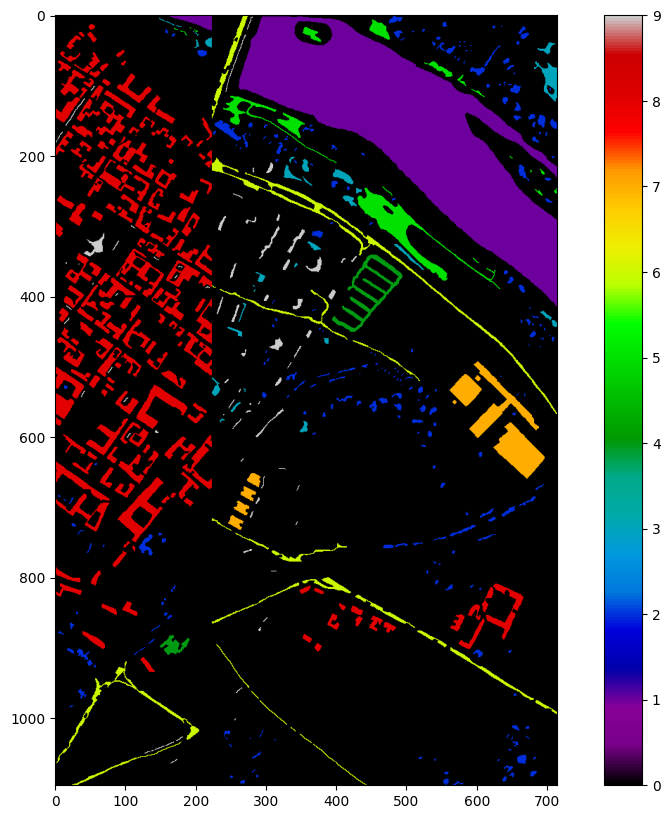

In [23]:
def plot_data(data):
  fig = plt.figure(figsize = (12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('on')
  plt.show()

plot_data(gt)

# Build CNN

In [24]:
n_ouputs = 10

In [28]:
#### (n,w,h,b) ####
x_train.shape

(72594, 3, 3, 102)

In [32]:
model = Sequential(name = 'Pavia_CNN')

model.add(Conv2D(64, kernel_size=(2,2), activation='linear', padding='same', input_shape=(3,3,102)))
model.add(LeakyReLU(alpha = 0.1))

model.add(Conv2D(128, (3,3), activation='linear', padding= 'same'))
model.add(LeakyReLU(alpha = 0.1))

model.add(Conv2D(128, (3,3), activation='linear', padding= 'same'))
model.add(LeakyReLU(alpha = 0.1))

model.add(Conv2D(256, (3,3), activation='linear', padding= 'same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPooling2D(pool_size=(2,2), padding= 'same'))

model.add(Flatten())

model.add(Dense(20, activation= 'linear'))
model.add(LeakyReLU(alpha = 0.1))
model.add(Dropout(0.4))

model.add(Dense(n_ouputs, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Pavia_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 64)       │        26,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │        20,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 563,494 (2.15 MB)

 Trainable params: 563,494 (2.15 MB)

 Non-trainable params: 0 (0.00 B)